In [1]:
# %pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [10]:

#this will mark the entire bright area green nad save it in the provided location


# Function to find and mark the entire bright ribbon area in green
def find_and_mark_bright_ribbon_area(frame):
    # Convert the frame to HSV color space to focus on brightness (Value channel)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Extract the Value channel (brightness)
    _, _, v = cv2.split(hsv)

    # Threshold the Value channel to detect bright areas (anything brighter than dark background)
    _, thresh = cv2.threshold(v, 50, 255, cv2.THRESH_BINARY)  # Threshold for non-dark areas (adjust 50 as needed)

    # Use morphological operations to enhance the detection of the ribbon area
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)  # Fill small gaps in the ribbon
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)   # Remove small noise

    # Find contours of the bright regions (ribbon)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the frame (marking the ribbon area in green)
    cv2.drawContours(frame, contours, -1, (0, 255, 0), -1)  # Draw filled in green

    return frame

def process_and_save_video(input_video_path, output_video_path):
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    # Get the properties of the input video
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Width of the frame
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Height of the frame
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for output video

    # Create the VideoWriter object to write the marked video
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Process the video frame by frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Break when no more frames

        # Mark the bright ribbon area in the current frame
        marked_frame = find_and_mark_bright_ribbon_area(frame.copy())

        # Write the frame with the marked ribbon area to the output video
        out.write(marked_frame)

    # Release the video objects
    cap.release()
    out.release()

    print(f"Marked video saved as {output_video_path}")

# Main function to run everything
def main(input_video_path, output_video_path):
    # Process the video and save the marked video
    process_and_save_video(input_video_path, output_video_path)

# Add the input video and output path here
input_video_path = '../picvid/ribbon_sliding.mp4'  # Path to the input video file
output_video_path = 'green/ribbon_sliding.mp4'  # Path to save the output video
main(input_video_path, output_video_path)


Marked video saved as green/ribbon_sliding.mp4


Saved frame 488 at frames/ribbon_sliding/marked_frame_488.png
Saved frame 976 at frames/ribbon_sliding/marked_frame_976.png
Saved frame 1464 at frames/ribbon_sliding/marked_frame_1464.png
Saved frame 1951 at frames/ribbon_sliding/marked_frame_1951.png


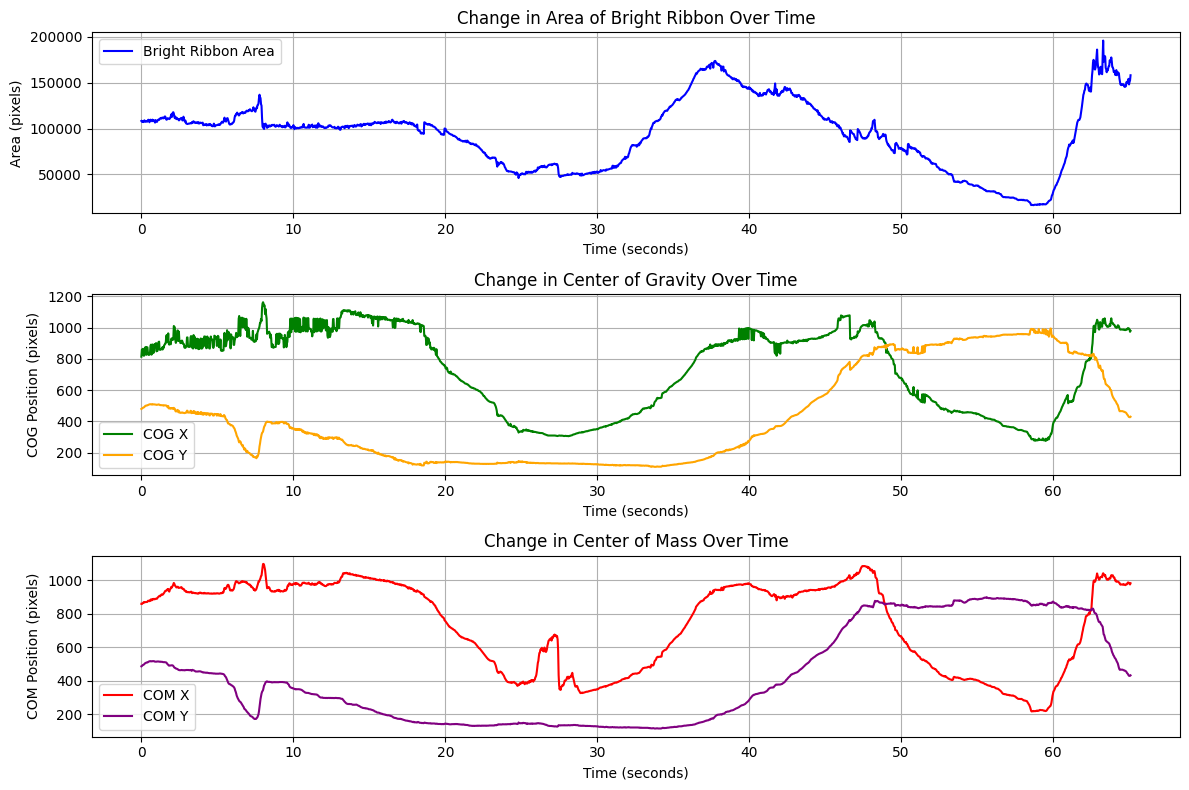

In [17]:

#This will save the area marked images and show the change in area, COG,COM due to deformation


def find_and_mark_bright_ribbon_area(frame):
    # Convert the frame to HSV color space to focus on brightness (Value channel)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Extract the Value channel (brightness)
    _, _, v = cv2.split(hsv)

    # Threshold the Value channel to detect bright areas
    _, thresh = cv2.threshold(v, 50, 255, cv2.THRESH_BINARY)  # Adjust the threshold value as needed

    # Use morphological operations to enhance the detection
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)  # Closing operation to fill small gaps
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)   # Opening operation to remove small noise

    # Find contours of the bright regions
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total area of the bright regions (contours)
    total_area = sum(cv2.contourArea(c) for c in contours)
    
    # Initialize variables to calculate center of gravity (COG) and center of mass (COM)
    cog_x, cog_y, com_x, com_y = 0, 0, 0, 0
    total_weight = 0

    # Calculate the COG as the centroid of the largest contour
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(largest_contour)
        if M["m00"] != 0:
            cog_x = int(M["m10"] / M["m00"])
            cog_y = int(M["m01"] / M["m00"])

        # Calculate COM as the weighted average of all contour centroids
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                area = cv2.contourArea(contour)
                com_x += cx * area
                com_y += cy * area
                total_weight += area

        if total_weight != 0:
            com_x = int(com_x / total_weight)
            com_y = int(com_y / total_weight)

    # Draw the contours on the frame (marking the ribbon area in green)
    cv2.drawContours(frame, contours, -1, (0, 255, 0), -1)  # Draw filled in green

    return frame, total_area, (cog_x, cog_y), (com_x, com_y)

# Function to process the video, calculate and save COG, COM, and save marked frames
def process_video_and_save_frames(input_video_path, output_folder):
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return [], [], [], [], []

    # Ensure the output folder exists, create if necessary
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get the properties of the input video
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames
    duration = frame_count / fps  # Total duration of the video in seconds

    areas = []  # List to store the areas of the bright ribbon in each frame
    times = []  # List to store the corresponding times
    cog_positions = []  # List to store center of gravity positions (cog_x, cog_y)
    com_positions = []  # List to store center of mass positions (com_x, com_y)

    # Indices of frames to save
    saved_frame_indices = [int(frame_count * 0.25), int(frame_count * 0.5), int(frame_count * 0.75), frame_count - 1]
    frame_idx = 0

    # Process the video frame by frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Break when no more frames

        # Find and mark the bright ribbon area in green, calculate COG and COM
        marked_frame, area, cog, com = find_and_mark_bright_ribbon_area(frame.copy())

        # Append the area, COG, COM and corresponding time (frame index / fps)
        areas.append(area)
        times.append(frame_idx / fps)  # Time in seconds
        cog_positions.append(cog)
        com_positions.append(com)

        # Save specific frames with the green-marked ribbon
        if frame_idx in saved_frame_indices:
            output_image_path = os.path.join(output_folder, f"marked_frame_{frame_idx}.png")
            cv2.imwrite(output_image_path, marked_frame)  # Save the frame
            print(f"Saved frame {frame_idx} at {output_image_path}")

        frame_idx += 1

    # Release the video object
    cap.release()

    return areas, times, cog_positions, com_positions

# Function to plot the change in area, COG, and COM over time
def plot_metrics_over_time(areas, times, cog_positions, com_positions):
    # Plot 1: Change in area over time
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(times, areas, color='blue', label="Bright Ribbon Area")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Area (pixels)')
    plt.title('Change in Area of Bright Ribbon Over Time')
    plt.legend()
    plt.grid(True)

    # Plot 2: Change in Center of Gravity (COG) over time
    cog_x = [pos[0] for pos in cog_positions]
    cog_y = [pos[1] for pos in cog_positions]

    plt.subplot(3, 1, 2)
    plt.plot(times, cog_x, label="COG X", color='green')
    plt.plot(times, cog_y, label="COG Y", color='orange')
    plt.xlabel('Time (seconds)')
    plt.ylabel('COG Position (pixels)')
    plt.title('Change in Center of Gravity Over Time')
    plt.legend()
    plt.grid(True)

    # Plot 3: Change in Center of Mass (COM) over time
    com_x = [pos[0] for pos in com_positions]
    com_y = [pos[1] for pos in com_positions]

    plt.subplot(3, 1, 3)
    plt.plot(times, com_x, label="COM X", color='red')
    plt.plot(times, com_y, label="COM Y", color='purple')
    plt.xlabel('Time (seconds)')
    plt.ylabel('COM Position (pixels)')
    plt.title('Change in Center of Mass Over Time')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Main function to run the processing, plotting, and saving frames
def main(input_video_path, output_folder):
    # Process the video and calculate the areas, COG, COM, and corresponding times, also save some marked frames
    areas, times, cog_positions, com_positions = process_video_and_save_frames(input_video_path, output_folder)

    # Plot the change in area, COG, and COM over time
    plot_metrics_over_time(areas, times, cog_positions, com_positions)

# Add the input video and out put image path here
input_video_path = '../picvid/ribbon_sliding.mp4'  # Path to the input video file
output_folder = 'frames/ribbon_sliding'  # here the frames will be saved
main(input_video_path, output_folder)
